In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 11.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
import optuna

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lucass0s0/polycystic-ovary-syndrome-pcos")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/polycystic-ovary-syndrome-pcos


In [ ]:
data=pd.read_csv(r"/kaggle/input/polycystic-ovary-syndrome-pcos/pcos_rotterdam_balanceado.csv")

In [ ]:
data1=data.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        3000 non-null   int64  
 1   BMI                        3000 non-null   float64
 2   Menstrual_Irregularity     3000 non-null   int64  
 3   Testosterone_Level(ng/dL)  3000 non-null   float64
 4   Antral_Follicle_Count      3000 non-null   int64  
 5   PCOS_Diagnosis             3000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 140.8 KB


<Axes: >

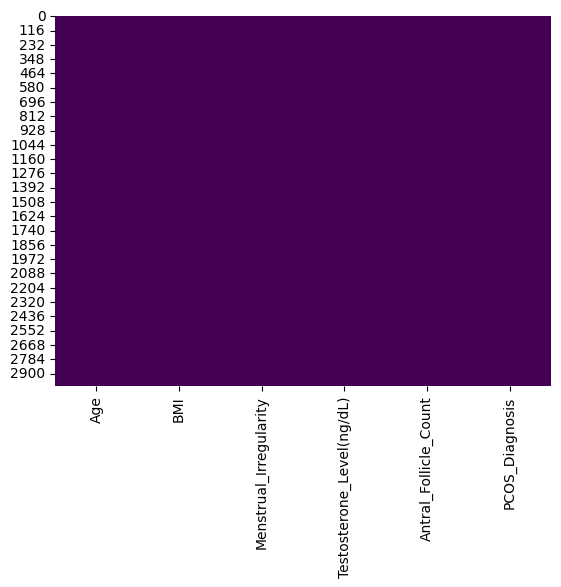

In [ ]:
sns.heatmap(data.isnull(),cbar=False,cmap='viridis')

From the above graph we can say that that data is not having outliers

In [ ]:
data.head(2)

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,29,21.2,0,46.1,9,0
1,20,20.5,0,59.4,6,0


In [ ]:
data["PCOS_Diagnosis"].value_counts()

,count
PCOS_Diagnosis,
0,2400
1,600


## from the above thing we can see that that the data is fully imbalanced

In [ ]:
data.describe()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,30.052667,23.646000,0.289333,57.228267,10.732333,0.200000
std,7.549982,4.510006,0.453529,18.171066,8.471478,0.400067
min,18.000000,8.500000,0.000000,20.500000,3.000000,0.000000
25%,24.000000,20.800000,0.000000,45.200000,5.000000,0.000000
50%,30.000000,23.400000,0.000000,53.200000,8.000000,0.000000
75%,36.000000,26.300000,1.000000,64.100000,11.000000,0.000000
max,44.000000,44.700000,1.000000,136.400000,39.000000,1.000000


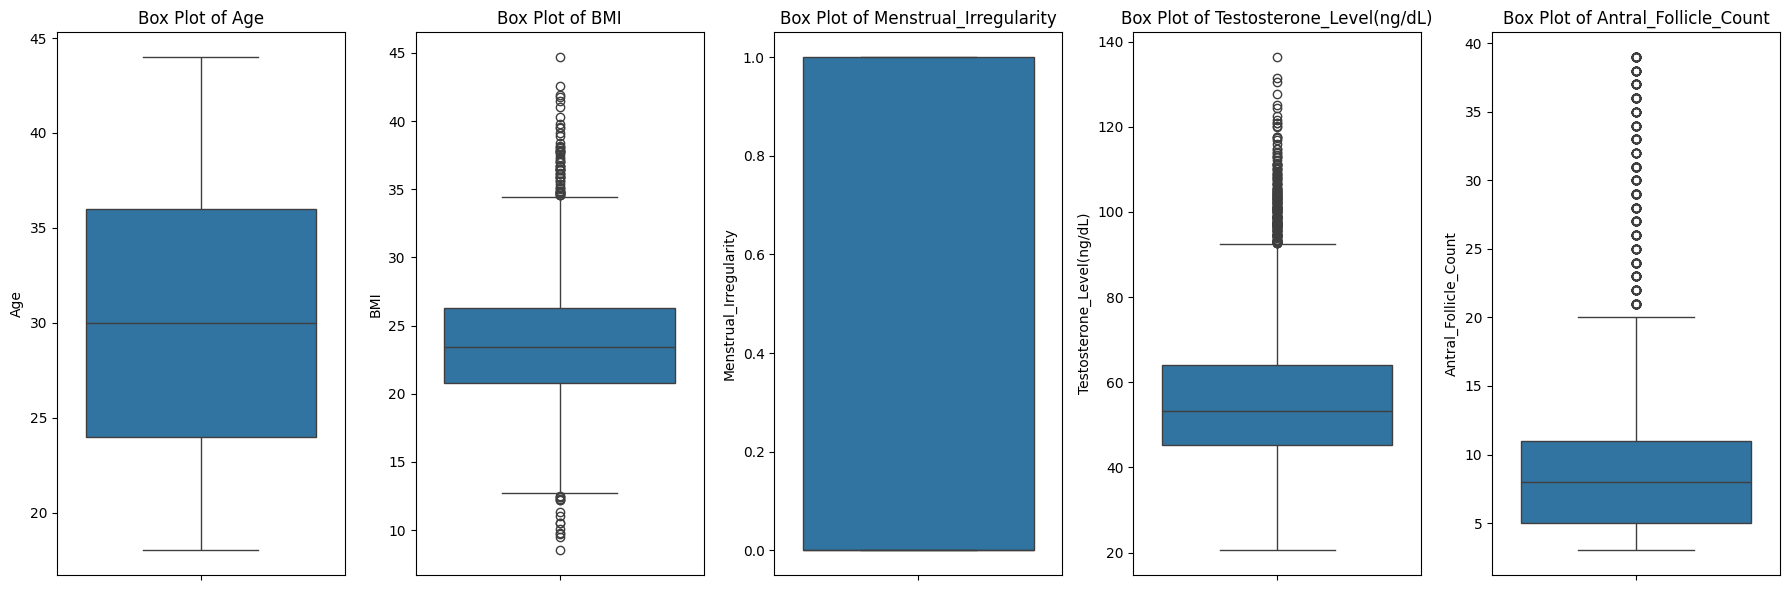

In [ ]:
numerical_features = ['Age', 'BMI', 'Menstrual_Irregularity', 'Testosterone_Level(ng/dL)', 'Antral_Follicle_Count',
       ]


fig, axes = plt.subplots(1, 5, figsize=(18, 6))


for i, feature in enumerate(numerical_features):
    sns.boxplot(y=data[feature], ax=axes[i])
    axes[i].set_title(f"Box Plot of {feature}")

plt.tight_layout()
plt.show()

From the above thing we can see that in our data we are having outliers but considering the domain we can say that the outliers are important

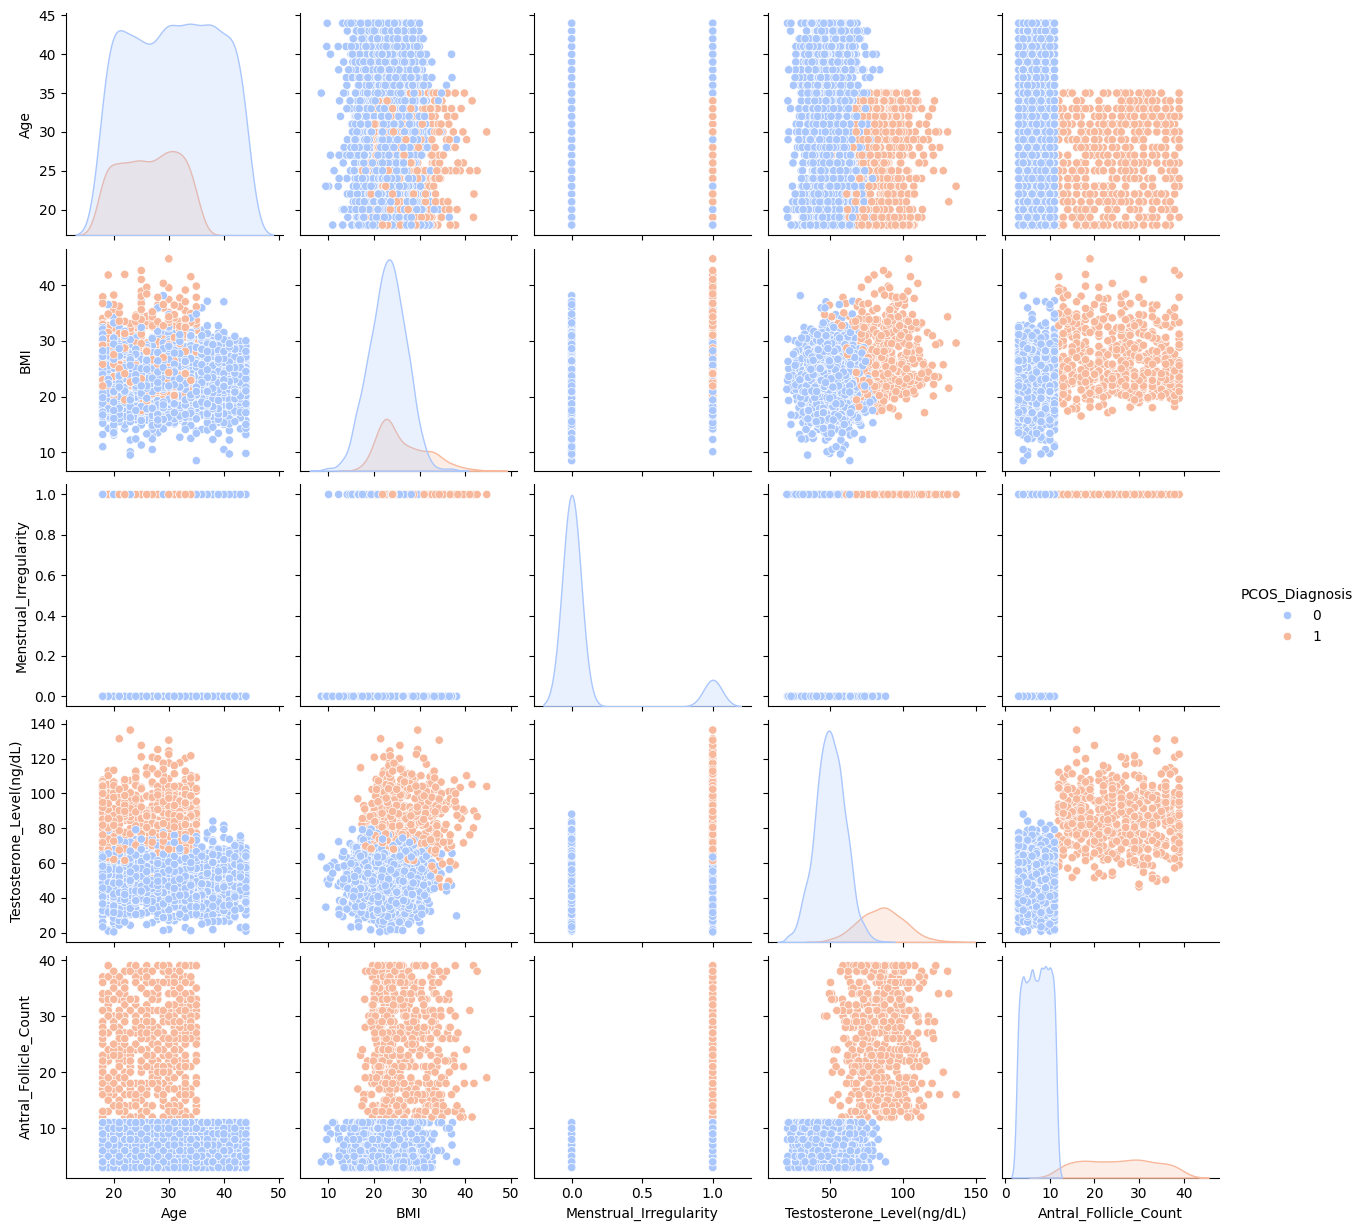

In [ ]:
data_numeric = data.select_dtypes(include=['number'])

sns.pairplot(data_numeric, hue="PCOS_Diagnosis", palette="coolwarm", diag_kind="kde")
plt.show()

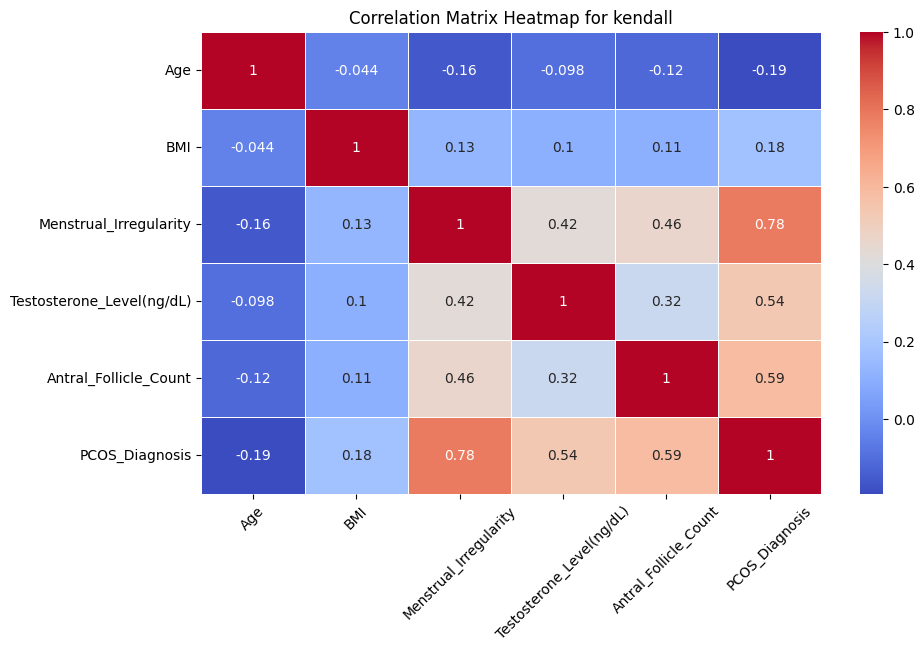

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data.corr(method='kendall'), annot=True, cmap='coolwarm', linewidths=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Correlation Matrix Heatmap for kendall")
plt.show()

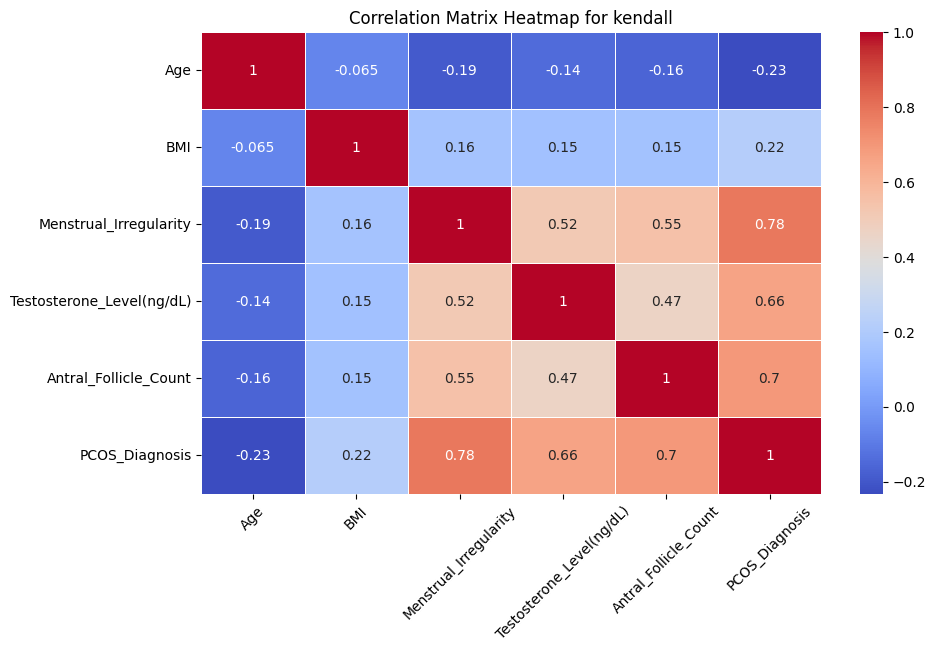

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data.corr(method='spearman'), annot=True, cmap='coolwarm', linewidths=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Correlation Matrix Heatmap for kendall")
plt.show()

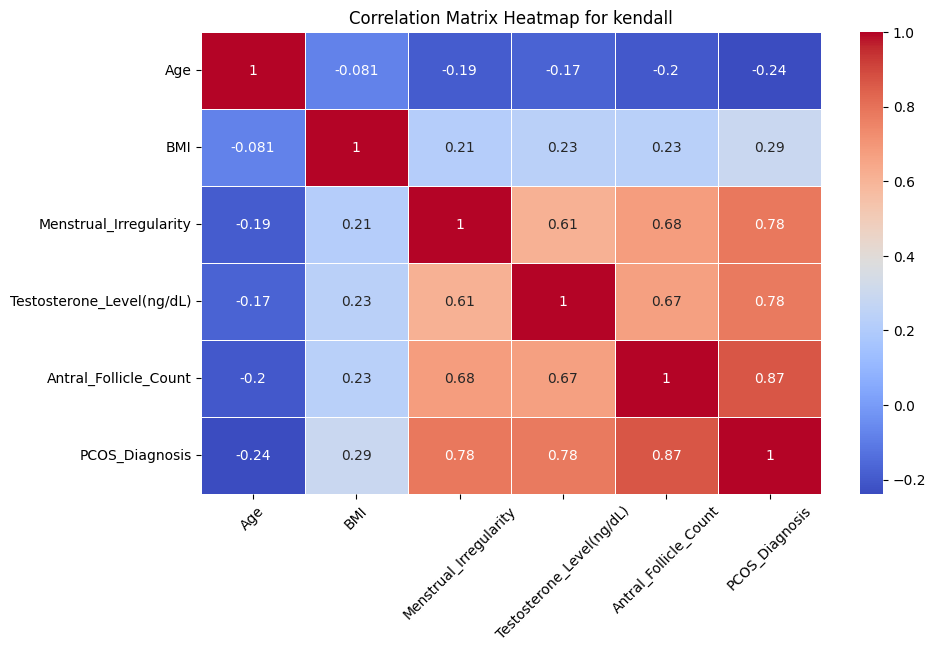

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(data.corr(method='pearson'), annot=True, cmap='coolwarm', linewidths=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.title("Correlation Matrix Heatmap for kendall")
plt.show()

In [ ]:
fv=data.iloc[:,:-1]
cv=data.iloc[:,-1]

In [ ]:
fv.head(2)

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count
0,29,21.2,0,46.1,9
1,20,20.5,0,59.4,6


In [ ]:
cv.head(2)

,PCOS_Diagnosis
0,0
1,0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(fv,cv,test_size=0.2,random_state=42,stratify=cv)

In [ ]:
Counter(y_train)

Counter({0: 1920, 1: 480})

In [ ]:
print("Before SMOTE:", Counter(y_train))


sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 1920, 1: 480})
After SMOTE: Counter({0: 1920, 1: 1920})


In [ ]:
rb=RobustScaler()
x_train_final=rb.fit_transform(X_train_resampled)
x_test_final=rb.transform(x_test)

In [ ]:
def objective(trail):
  algo=trail.suggest_categorical('algo',['knn','dt','lor','svc'])
  if algo=="knn":
    k=n_neighbors=trail.suggest_int('k',3,100)
    weights=trail.suggest_categorical('weights',['uniform','distance'])
    p1=trail.suggest_int("distance",1,2)
    alg=trail.suggest_categorical("algorithm",["ball_tree","kd_tree","brute"])
    model=KNeighborsClassifier(n_neighbors=k,weights=weights,p=p1,algorithm=alg)
    model.fit(x_train_final,y_train_resampled)
  elif algo=="dt":
    max_depth=trail.suggest_int("max_depth",1,50)
    min_samples_split=trail.suggest_int("min_samples_split",2,50)
    min_samples_leaf=trail.suggest_int("min_samples_leaf",1,50)
    min_weight_fraction_leaf=trail.suggest_float("min_weight_fraction_leaf",0.0,0.15)
    min_impurity_decrease=trail.suggest_float("min_impurity_decrease",0.0,1.0)
    max_features=trail.suggest_int("max_features",1,5)
    model=DecisionTreeClassifier(max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,min_impurity_decrease=min_impurity_decrease,max_features=max_features)
    model.fit(x_train_final,y_train_resampled)
  elif algo=="lor":
    solver = trail.suggest_categorical('solver', ["liblinear", "newton-cholesky"])
    penalty = trail.suggest_categorical('penalty', ["l1", "l2"]) if solver == "liblinear" else "l2"
    c = trail.suggest_categorical("c", [0.001, 0.01, 0.1, 10, 100])
    model = LogisticRegression(solver=solver, penalty=penalty, C=c)
    model.fit(x_train_final, y_train_resampled)
  elif algo=="svc":
    x=trail.suggest_categorical("x",[0.001,0.01,0.1,1,5,10,100])
    kernel=trail.suggest_categorical("kernel",["linear","poly","rbf","sigmoid"])
    model=SVC(C=x,kernel=kernel,probability=True)
    model.fit(x_train_final,y_train_resampled)

  cv_score=cross_validate(model,x_train_final,y_train_resampled,cv=3,scoring="neg_log_loss",return_train_score=True)['test_score'].mean()
  train_score=cross_validate(model,x_train_final,y_train_resampled,cv=3,scoring="neg_log_loss",return_train_score=True)['train_score'].mean()
  trail.set_user_attr(key="cv_score",value=cv_score)
  trail.set_user_attr(key="train_score",value=train_score)
  return cv_score

In [ ]:
from optuna.samplers import TPESampler

In [ ]:
study=optuna.create_study(direction="maximize",sampler=TPESampler())

[I 2025-04-22 14:30:13,155] A new study created in memory with name: no-name-4cb50b08-3aa1-4d0a-8359-d526df031397


In [ ]:
study.optimize(objective,n_trials=300,n_jobs=-1)

[I 2025-04-22 14:30:15,145] Trial 0 finished with value: -0.6931471805599453 and parameters: {'algo': 'dt', 'max_depth': 36, 'min_samples_split': 26, 'min_samples_leaf': 26, 'min_weight_fraction_leaf': 0.014043700268103242, 'min_impurity_decrease': 0.8141475973277437, 'max_features': 5}. Best is trial 0 with value: -0.6931471805599453.
[I 2025-04-22 14:30:15,230] Trial 2 finished with value: -0.23104906018664859 and parameters: {'algo': 'dt', 'max_depth': 11, 'min_samples_split': 22, 'min_samples_leaf': 18, 'min_weight_fraction_leaf': 0.02671087913810329, 'min_impurity_decrease': 0.43215602730621605, 'max_features': 2}. Best is trial 2 with value: -0.23104906018664859.
[I 2025-04-22 14:30:15,858] Trial 3 finished with value: -0.012884164929019124 and parameters: {'algo': 'knn', 'k': 26, 'weights': 'uniform', 'distance': 2, 'algorithm': 'kd_tree'}. Best is trial 3 with value: -0.012884164929019124.
[I 2025-04-22 14:30:15,969] Trial 4 finished with value: -0.0011244574145992225 and param

In [ ]:
data1=study.trials_dataframe()

In [ ]:
data1

,number,value,datetime_start,datetime_complete,duration,params_algo,params_algorithm,params_c,params_distance,params_k,...,params_min_samples_leaf,params_min_samples_split,params_min_weight_fraction_leaf,params_penalty,params_solver,params_weights,params_x,user_attrs_cv_score,user_attrs_train_score,state
0,0,-6.931472e-01,2025-04-22 14:30:15.053380,2025-04-22 14:30:15.145136,0 days 00:00:00.091756,dt,NaN,NaN,NaN,NaN,...,26.0,26.0,0.014044,NaN,NaN,NaN,NaN,-6.931472e-01,-6.931472e-01,COMPLETE
1,1,-2.021321e-02,2025-04-22 14:30:15.055952,2025-04-22 14:30:17.070789,0 days 00:00:02.014837,knn,ball_tree,NaN,2.0,85.0,...,NaN,NaN,NaN,NaN,NaN,distance,NaN,-2.021321e-02,-2.220446e-16,COMPLETE
2,2,-2.310491e-01,2025-04-22 14:30:15.149672,2025-04-22 14:30:15.230254,0 days 00:00:00.080582,dt,NaN,NaN,NaN,NaN,...,18.0,22.0,0.026711,NaN,NaN,NaN,NaN,-2.310491e-01,-4.620981e-01,COMPLETE
3,3,-1.288416e-02,2025-04-22 14:30:15.234080,2025-04-22 14:30:15.857739,0 days 00:00:00.623659,knn,kd_tree,NaN,2.0,26.0,...,NaN,NaN,NaN,NaN,NaN,uniform,NaN,-1.288416e-02,-1.249349e-02,COMPLETE
4,4,-1.124457e-03,2025-04-22 14:30:15.860374,2025-04-22 14:30:15.968706,0 days 00:00:00.108332,lor,NaN,100.0,NaN,NaN,...,NaN,NaN,NaN,l1,liblinear,NaN,NaN,-1.124457e-03,-5.542934e-04,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,-2.220446e-16,2025-04-22 14:31:43.665403,2025-04-22 14:31:43.929049,0 days 00:00:00.263646,dt,NaN,NaN,NaN,NaN,...,41.0,11.0,0.137777,NaN,NaN,NaN,NaN,-2.220446e-16,-2.220446e-16,COMPLETE
296,296,-2.220446e-16,2025-04-22 14:31:43.933528,2025-04-22 14:31:44.200894,0 days 00:00:00.267366,dt,NaN,NaN,NaN,NaN,...,35.0,50.0,0.146020,NaN,NaN,NaN,NaN,-2.220446e-16,-2.220446e-16,COMPLETE
297,297,-2.220446e-16,2025-04-22 14:31:44.207110,2025-04-22 14:31:44.560845,0 days 00:00:00.353735,dt,NaN,NaN,NaN,NaN,...,37.0,49.0,0.122208,NaN,NaN,NaN,NaN,-2.220446e-16,-2.220446e-16,COMPLETE
298,298,-6.931472e-01,2025-04-22 14:31:44.566073,2025-04-22 14:31:44.732945,0 days 00:00:00.166872,dt,NaN,NaN,NaN,NaN,...,47.0,39.0,0.140584,NaN,NaN,NaN,NaN,-6.931472e-01,-6.931472e-01,COMPLETE


In [ ]:
data2=data1[data1['params_algo']=='dt']

In [ ]:
data2.head(2)

,number,value,datetime_start,datetime_complete,duration,params_algo,params_algorithm,params_c,params_distance,params_k,...,params_min_samples_leaf,params_min_samples_split,params_min_weight_fraction_leaf,params_penalty,params_solver,params_weights,params_x,user_attrs_cv_score,user_attrs_train_score,state
0,0,-0.693147,2025-04-22 14:30:15.053380,2025-04-22 14:30:15.145136,0 days 00:00:00.091756,dt,NaN,NaN,NaN,NaN,...,26.0,26.0,0.014044,NaN,NaN,NaN,NaN,-0.693147,-0.693147,COMPLETE
2,2,-0.231049,2025-04-22 14:30:15.149672,2025-04-22 14:30:15.230254,0 days 00:00:00.080582,dt,NaN,NaN,NaN,NaN,...,18.0,22.0,0.026711,NaN,NaN,NaN,NaN,-0.231049,-0.462098,COMPLETE


In [ ]:
study.best_params

{'algo': 'dt',
 'max_depth': 49,
 'min_samples_split': 50,
 'min_samples_leaf': 50,
 'min_weight_fraction_leaf': 0.1480942127023968,
 'min_impurity_decrease': 0.0014778172471212603,
 'max_features': 5}

In [ ]:
study.best_value


-2.2204460492503136e-16

In [ ]:
dt=DecisionTreeClassifier(max_depth=4,min_samples_split=34,min_samples_leaf=21,min_weight_fraction_leaf=0.1482357699973427,min_impurity_decrease=0.1605871642146124,max_features=4)

In [ ]:
dt=DecisionTreeClassifier(max_depth=49,min_samples_split=50,min_samples_leaf=50,min_weight_fraction_leaf=0.1480942127023968,min_impurity_decrease=0.0014778172471212603,max_features=5)

In [ ]:
model=dt.fit(x_train_final,y_train_resampled)

In [ ]:
from sklearn.metrics import accuracy_score,log_loss

In [ ]:
log_loss(y_test,model.predict(x_test_final))

2.2204460492503136e-16

In [ ]:
accuracy_score(y_test,model.predict(x_test_final))

1.0

In [ ]:
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline

In [ ]:
ct=ColumnTransformer(transformers=[('rb',RobustScaler(),make_column_selector(dtype_include='number'))])

In [ ]:
dt1=DecisionTreeClassifier(max_depth=4,min_samples_split=34,min_samples_leaf=21,min_weight_fraction_leaf=0.1482357699973427,min_impurity_decrease=0.1605871642146124,max_features=4)

In [ ]:
final_pl = Pipeline(steps=[
    ('transformations', ct),
    ('estimator', dt1)
])

In [ ]:
final_pl.fit(X_train_resampled,y_train_resampled)

Pipeline(steps=[('transformations',
                 ColumnTransformer(transformers=[('rb', RobustScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x78f918b78f50>)])),
                ('estimator',
                 DecisionTreeClassifier(max_depth=4, max_features=4,
                                        min_impurity_decrease=0.1605871642146124,
                                        min_samples_leaf=21,
                                        min_samples_split=34,
                                        min_weight_fraction_leaf=0.1482357699973427))])

In [ ]:
accuracy_score(y_test,final_pl.predict(x_test))

1.0

In [ ]:
import pickle

In [ ]:
pickle.dump(final_pl, open("final_model.pkl", "wb"))